# Tic Tac Toe - Round 2

We expect an optimal tic tac toe player to never lose a game. However, Team B's dynamic programming (DP) model had a positive win rate against Team A's DP model when Team B played first. We attribute this to Team A only training on starting positions where Team A played first.

In this version, Team A attempts a Q-Learning model that trains on going both first and second and on a variety of openings.

# Summary of Outcomes

Team B once again triumphs. Team A and Team B consistently tie when the starting position is the standard blank board. However, when certain random openings are forced, Team B has a positive win rate.

We attribute the reason to be that Team B's DP model has seen every single game state, whereas Team A's Q-Learning model has only seen a subset of game states. When a random opening causes a strange game state that Team A does not recognize, Team A is prone to misplaying or playing an illegal move.

Furthermore, the Team B DP model is much faster to train at this scale. Conclude that DP beats Q-Learning for a game of the scope of tic tac toe.

In [1]:
import os

# Set current working directory to "inde597_intergroup" (the outermost folder in the repository) for proper package imports
os.chdir("C:/Users/georg/OneDrive/Documents/Rice University/Current Coursework/Inde597 Deep and Reinforcement Learning/Code/inde597_intergroup")

# Environment

In [45]:
import numpy as np
from environments import *

class TicTacToe(EnvironmentVersus):
    '''
    Implements tic tac toe
    States are stored as a 9-tuple of flags -1, 0, 1
        1  agent 0 mark
        -1 agent 1 mark
        0  no mark
    Actions are represented as an integer between 0 and 8, inclusive, indicating the index of the square to play in
    '''
    # Reward for illegal move
    illegal_reward = -100
    
    # Container for all 8 ways to get 3 in a row
    triples = ((0, 1, 2),
               (3, 4, 5),
               (6, 7, 8),
               (0, 3, 6),
               (1, 4, 7),
               (2, 5, 8),
               (0, 4, 8),
               (2, 4, 6))
    
    def __init__(self, agents):
        '''
        Initialize this environment
        INPUT
            agents; 2-length Sequence of Agents
        '''
        if len(agents) != 2:
            raise Exception("Expected 2 agents.")
        super().__init__(agents)
    
    def get_actions(self):
        '''
        RETURNS all possible moves
        '''
        return tuple(range(9))
    
    def step(self, action:int, agent_ind:int):
        '''
        Steps in the current game by marking the player move
        Mutates self.current_state to be the next state
        INPUT
            action; action taken at this step
            agent_ind; index of the agent who took this action
        RETURNS 4 arguments
            0: next state after the step
            1: reward for the action
            2: boolean flag whether the environment has terminated
            3: the index of the agent whose turn it is
        '''        
        # If move is illegal, end the game with game loss penalty
        if self.current_state[action] != 0:
            return self.current_state, self.illegal_reward, True, None
        
        # Make appropriate mark
        next_state = list(self.current_state)
        if agent_ind == 0:
            next_state[action] = 1
        elif agent_ind == 1:
            next_state[action] = -1
        else:
            raise Exception("Invalid agent_ind. Expected 0 or 1.")
        self.current_state = tuple(next_state)
        
        # Check for wins
        for triple in self.triples:
            line_sum = sum([self.current_state[cell] for cell in triple])
            if (line_sum == 3 and agent_ind == 0) or (line_sum ==-3 and agent_ind == 1):
                return self.current_state, 1, True, None
        
        # Check for tie
        if 0 not in self.current_state:
            return self.current_state, 0, True, None
                
        # Return
        return self.current_state, 0, False, 1 - agent_ind
        
    def reset(self, opening=tuple([0] * 9)):
        '''
        Resets the board. If an opening is provided, resets the board to the opening state.
        INPUT
            opening; a tuple representing the opening state
        RETURNS
            the opening state
        '''
        self.current_state = opening
        return self.current_state
    
    def reinterpret_state_for_agent(self, state, agent_ind):
        '''
        Remaps the 1 and -1 markings for the given indexed agent
        INPUT
            state; tuple representing board state
            agent_ind; indexed agent
        '''
        if agent_ind == 0:
            return state
        elif agent_ind == 1:
            return tuple([-val for val in state])
        else:
            raise Exception("Invalid agent_ind. Expected 0 or 1.")
        
    def render(self, state=tuple([0] * 9), is_0_first=True):
        '''
        Prints the given state as a board
        INPUT
            state; 9-tuple representing the state
            is_0_first; boolean if agent 0 is the first player
        '''
        markers = [" "] * 9
        for ind, mark in enumerate(state):
            match mark:
                case 1:
                    if is_0_first:
                        markers[ind] = "X"
                    else:
                        markers[ind] = "O"
                case -1:
                    if is_0_first:
                        markers[ind] = "O"
                    else:
                        markers[ind] = "X"
                case 0:
                    markers[ind] = " "
        msg = f"{markers[0]}|{markers[1]}|{markers[2]}"
        msg += "\n-----"
        msg += f"\n{markers[3]}|{markers[4]}|{markers[5]}"
        msg += "\n-----"
        msg += f"\n{markers[6]}|{markers[7]}|{markers[8]}"
        print()
        print(msg)
        print()
        
    def compute_game_end_reward(self, history:List, agent_ind:int):
        '''
        Computes the reward accrued by the given indexed agent at the end of the game
        If given player was the last player to move, returns 0
        If given player was the opponent of the last player to move, returns -1 if loss, 1 if won, and 1 if won by illegal move
        INPUT
            history; episode pathway as a list of 4-tuples, each of which has components:
                0: state
                1: action
                2: reward
                3: index of agent
                The last element is the final state, given as (final_state, None, None, None)
            agent_ind; integer index of the agent to compute the game end rewards for
        RETURNS
            amount by which to modify the reward of the last action made by the indexed agent
        '''
        # Check that the last element in the pathway is a final_state,
        # indicated by None as the index of the agent
        if history[-1][3] is not None:
            raise Exception("The last episode pathway element had a non-None agent_ind, indicating the episode is not yet done.")

        # Get agent and reward of the last action
        last_agent_ind = history[-2][3]
        last_reward = history[-2][2]

        # If the last agent and the given agent are the same, return 0
        if last_agent_ind == agent_ind:
            return 0
        
        # Return the negative of the reward gained by the last agent
        if last_reward == self.illegal_reward:
            return 1
        else:
            return -last_reward

# Train Team A

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:44<00:00, 2229.75it/s]


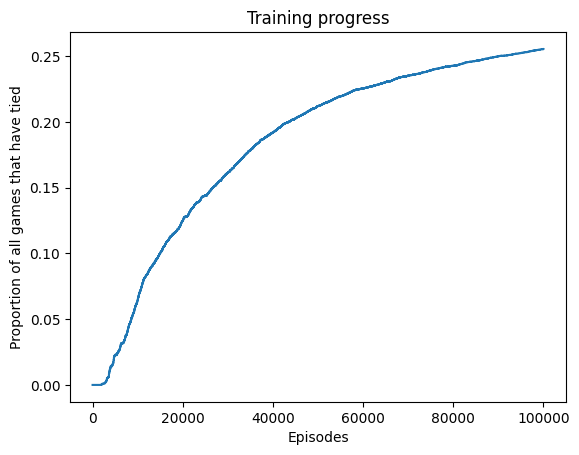

In [120]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from tic_tac_toe.team_a.temporal_difference import QLearning

# Training parameters
N_EPISODES = 10 ** 5
PROB_RANDOM_OPENING = 0.8

# Intialize the agent and environment
team_a = QLearning(eps=0.2, gamma=1, alpha=0.5)
train_game = TicTacToe((team_a, team_a))

# Run training episodes on blank board. Track the ties over time to show progres.
tie_list = []
for _ in tqdm(range(N_EPISODES)):
    
    # Construct opening, with 0.5 probability of a random opening
    first_agent_ind = np.random.choice(range(2))
    random_opening = [0] * 9
    if np.random.random() < PROB_RANDOM_OPENING:
        random_opening[np.random.choice(range(9))] = -1 if first_agent_ind == 0 else 1
    random_opening = tuple(random_opening)

    # Play game
    _, rewards = train_game.play_game((random_opening, first_agent_ind))
    tie_list.append(int(rewards == [0, 0]))
    
# Plot the proportion of games played that are ties
prop_tie = np.cumsum(tie_list) / (np.array(range(len(tie_list))) + 1)
plt.plot(prop_tie)
plt.xlabel("Episodes")
plt.ylabel("Proportion of all games that have tied")
plt.title("Training progress")
plt.show()

# Set the agent to all greedy
team_a.eps = 0

We expect an optimal player to tie every game against itself. The tie proportion is low because epsilon-greedy on-policy will often select illegal moves when exploring.

# Train Team B

In [82]:
import tqdm as tqdm
import numpy as np

class envB:
    """
    This class is used to define a tic tac toe environment
    """

    def __init__(self):
        self.previous_board = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.board = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.turn = 1
        self.winner = 0

    def reset(self, position = None):
        if position is None:
            position = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        if type(position) != list:
            raise ValueError("The position must be a list of 9 elements")
        if len(position) != 9:
            raise ValueError("The position must be a list of 9 elements")
        self.board = position
        self.turn = 1
        self.winner = 0
        return self.board

    def pop(self):
        """
        This function is used to remove the last move
        """
        self.board = self.previous_board
        self.turn = -self.turn
        self.winner = 0

    def step(self, action):
        """
        This function is used to make a move on the board
        Returns:
            - The new board
            - The reward (0 if there is no winner)
            - A boolean indicating if the game is finished
        If the action is not possible, the game is forfeited with a reward of -10 * self.turn
        """
        self.previous_board = self.board.copy()
        if self.board[action] == 0:
            self.board[action] = self.turn
            self.turn = -self.turn
            self.winner = self.check_winner()
            done = self.winner != 0 or 0 not in self.board
            return self.board, self.winner, done
        else:
            print("Invalid move!")
            print(self)
            print(f"Action: {action}")
            return self.board, -10 * self.turn, True

    def check_winner(self, board = None):
        """
        This function is used to check if there is a winner
        """
        if board is None:
            board = self.board
        for i in range(3):
            if board[i] == board[i + 3] == board[i + 6] != 0:
                return board[i]
            if board[i * 3] == board[i * 3 + 1] == board[i * 3 + 2] != 0:
                return board[i * 3]
        if board[0] == board[4] == board[8] != 0:
            return board[0]
        if board[2] == board[4] == board[6] != 0:
            return board[2]
        if 0 not in board:
            return 0
        return 0
    
    def get_actions(self):
        """
        This function is used to get the possible actions
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def __str__(self):
        """
        This function is used to print the board
        """
        symbols = {0: " ", 1: "X", -1: "O"}
        return f"{symbols[self.board[0]]}|{symbols[self.board[1]]}|{symbols[self.board[2]]}\n-----\n{symbols[self.board[3]]}|{symbols[self.board[4]]}|{symbols[self.board[5]]}\n-----\n{symbols[self.board[6]]}|{symbols[self.board[7]]}|{symbols[self.board[8]]}"
    
class AgentB():
    """
    This class is used to define a tic tac toe agent
    """

    def __init__(self, env):
        self.env = env
        self.init_policy()

    def init_policy(self):
        """
        This function is used to initialize the policy
        """
        self.s_plus, self.s = enumerate_states()
        self.terminals = {s for s in self.s_plus if s not in self.s}
        self.values = {}
        self.policy = {}

        # initialize the values of the terminal states to 0
        # initialize the policy to random and value to arbitrary value for the non
        # terminal states
        for state in self.s_plus:
            if state in self.s:
                self.values[state] = .1
                self.policy[state] = 0
            else:
                self.values[state] = 0

        print("Initialization done!")

    def get_value(self, state):
        """
        This function is used to get the value of a state
        """
        for iso in get_isomorphisms(state):
            if tuple(iso) in self.values:
                return self.values[tuple(iso)]
        else:
            raise ValueError("The state is not in the state space")
    
    def get_policy(self, state):
        e = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        r1 = [2, 5, 8, 1, 4, 7, 0, 3, 6]
        r2 = [8, 7, 6, 5, 4, 3, 2, 1, 0]
        r3 = [6, 3, 0, 7, 4, 1, 8, 5, 2]
        s = [2, 1, 0, 5, 4, 3, 8, 7, 6]
        sr1 = [0, 3, 6, 1, 4, 7, 2, 5, 8]
        sr2 = [6, 7, 8, 3, 4, 5, 0, 1, 2]
        sr3 = [8, 5, 2, 7, 4, 1, 6, 3, 0]
        symmetries = [e, r1, r2, r3, s, sr1, sr2, sr3]

        for s, iso in enumerate(get_isomorphisms(state)):
            if tuple(iso) in self.policy:
                # the symmetry
                sym = symmetries[s]
                return sym[self.policy[tuple(iso)]]
        else:
            raise ValueError("The state is not in the state space")
            
    def set_value(self, state, value):
        """
        This function is used to set the value of a state
        """
        for iso in get_isomorphisms(state):
            if tuple(iso) in self.values:
                self.values[tuple(iso)] = value
                return True
        else:
            raise ValueError("The state is not in the state space")
        
    def set_policy(self, state, action):
        for iso in get_isomorphisms(state):
            if tuple(iso) in self.policy:
                self.policy[tuple(iso)] = action
                return True
        else:
            raise ValueError("The state is not in the state space")
       
    def value_iteration(self, gamma = 1, theta = 1e-5):
        delta = np.inf
        while delta > theta:
            delta = 0
            for state in tqdm.tqdm(self.s):
                self.env.reset(list(state))
                old_v = self.get_value(state)
                v = - np.inf
                for action in self.env.get_actions():
                    next_state, reward, done = self.env.step(action)
                    v = max(v, reward + gamma * -1 * self.get_value(tuple(-1 * i for i in next_state)))
                    self.env.pop()
                self.set_value(state, v)
                delta = max(delta, abs(old_v - v))
        
        # output policy according to the value function
        for state in self.s:
            self.env.reset(list(state))
            v = - np.inf
            for action in self.env.get_actions():
                next_state, reward, done = self.env.step(action)
                if reward + gamma * -1 * self.get_value(tuple(-1 * i for i in next_state)) > v:
                    v = reward + gamma * -1 * self.get_value(tuple(-1 * i for i in next_state))
                    best_action = action
                self.env.pop()
            self.set_policy(state, best_action)

    def train(self, gamma = .9, theta = 1e-5):
        self.value_iteration(gamma, theta)
        print("Value iteration done!")

    def self_test(self):
        """
        This function is used to test the agent
        """
        self.env.reset()
        print(self.env)
        state = self.env.board
        done = False
        while not done:
            action = self.get_policy(tuple(state))
            state, _, done = self.env.step(action)
            state = [-1 * i for i in state]
            print(self.env)
            print()
        if self.env.check_winner() == 0:
            print("It's a draw!")
        elif self.env.check_winner() == 1:
            print("X wins!")
        else:
            print("O wins!")
    
    def play_random(self, n=10000):
        """
        This function is used to play random games
        """
        Xwins = 0
        Xdraws = 0
        Xlosses = 0

        Owins = 0
        Odraws = 0
        Olosses = 0
        for game in tqdm.tqdm(range(n)):
            symbol = game % 2 * 2 - 1

            self.env.reset()
            state = self.env.board
            done = False
            while not done:
                if symbol == self.env.turn:
                    action = self.get_policy(tuple(state))
                else:
                    action = np.random.choice(self.env.get_actions())
                state, _, done = self.env.step(action)
                state = [-1 * i for i in state]
            
            if self.env.check_winner() == 0:
                if symbol == 1:
                    Xdraws += 1
                else:
                    Odraws += 1
            elif self.env.check_winner() == symbol:
                if symbol == 1:
                    Xwins += 1
                else:
                    Owins += 1
            else:
                if symbol == 1:
                    Xlosses += 1
                else:
                    Olosses += 1
        print(f"for X: wins = {Xwins}, draws = {Xdraws}, losses = {Xlosses}")
        print(f"for O: wins = {Owins}, draws = {Odraws}, losses = {Olosses}")
        return Xwins, Xdraws, Xlosses, Owins, Odraws, Olosses

def check_symmetry(board1, board2):
    if board1 in get_isomorphisms(board2):
        return True
        

def get_isomorphisms(board):
    e = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    r1 = [2, 5, 8, 1, 4, 7, 0, 3, 6]
    r2 = [8, 7, 6, 5, 4, 3, 2, 1, 0]
    r3 = [6, 3, 0, 7, 4, 1, 8, 5, 2]
    s = [2, 1, 0, 5, 4, 3, 8, 7, 6]
    sr1 = [0, 3, 6, 1, 4, 7, 2, 5, 8]
    sr2 = [6, 7, 8, 3, 4, 5, 0, 1, 2]
    sr3 = [8, 5, 2, 7, 4, 1, 6, 3, 0]
    symmetries = [e, r1, r2, r3, s, sr1, sr2, sr3]
    return [[board[i] for i in symmetry] for symmetry in symmetries]


def enumerate_states():
    """
    This function is used to enumerate all the possible states  and corresponding actions of the tic tac toe game
    UPTO ISOMORPHISM

    1 indicates agent's symbol when it's their turn so the number of 1s is at least the number of -1s minus 1
    and at most the number of -1s
    """
    isomorphic_boards = {}
    non_terminal = set()
    for i in range(3 ** 9):
        board = []
        for j in range(9):
            board.append((i // (3 ** j)) % 3 - 1)
        if board.count(1) < board.count(-1) - 1 or board.count(1) > board.count(-1):
            continue
        iso = False
        if (board.count(1), board.count(-1)) not in isomorphic_boards:
            isomorphic_boards[(board.count(1), board.count(-1))] = []

        for ib in isomorphic_boards[(board.count(1), board.count(-1))]:
            if check_symmetry(board, ib):
                iso = True
                break
        if iso:
            continue
        
        # check that the board is valid (i.e. if both players have 3 in a row, the board
        # is invalid)
        
        winners = num_winners(board)
        if winners > 1: 
            continue
        if winners == 0 and board.count(0) > 0:
            non_terminal.add(tuple(board))
        
        isomorphic_boards[(board.count(1), board.count(-1))].append(board)

    s_plus = set()
    for k, v in isomorphic_boards.items():
        for board in v:
            s_plus.add(tuple(board))
    s = non_terminal
    return s_plus, s

def num_winners(board):
    winners = set()
    for i in range(3):
        if board[i] == board[i + 3] == board[i + 6] != 0:
            winners.add(board[i])
        if board[i * 3] == board[i * 3 + 1] == board[i * 3 + 2] != 0:
            winners.add(board[i * 3])
        if board[0] == board[4] == board[8] != 0:
            winners.add(board[0])
        if board[2] == board[4] == board[6] != 0:
            winners.add(board[2])
    return len(winners)

def display_policy(agent, board):
    move = agent.get_policy(tuple(board))
    if board[move] == 0:
        board[move] = 10
    else:
        raise ValueError("The move is not possible: " + str(move))
    symbols = {0: " ", 1: "X", -1: "O", 10: "*"}
    print( f"{symbols[board[0]]}|{symbols[board[1]]}|{symbols[board[2]]}\n-----\n{symbols[board[3]]}|{symbols[board[4]]}|{symbols[board[5]]}\n-----\n{symbols[board[6]]}|{symbols[board[7]]}|{symbols[board[8]]}")
    
class WrapAgentB(Agent):
    
    mdl = None # the model trained on Team B technology
    
    def __init__(self, mdl):
        '''
        Sets model
        '''
        self.mdl = mdl
    
    def play(self, state):
        return self.mdl.get_policy(list(state))

In [85]:
tic_tac_toe = envB()
B = AgentB(tic_tac_toe)
B.train()

team_b = WrapAgentB(B)

Initialization done!


100%|█████████████████████████████████████████████████████████████████████████████| 627/627 [00:00<00:00, 11425.34it/s]

Value iteration done!


# Play a game

In [96]:
# Make environment
test_game = TicTacToe((team_a, team_b))

In [114]:
# Get game outcome
history, rewards = test_game.play_game()

# Victor
if history[0][3] == 0:
    print("A played first.")
    first_agent_ind = 0
else:
    print("B played first.")
    first_agent_ind = 1

# Outcome
if rewards[0] > rewards[1]:
    print("A won.")
elif rewards[1] > rewards[0]:
    print("B won.")
else:
    print("Tie.")

# Render
for state, _, _, _ in history:
    test_game.render(state, 1 - first_agent_ind)

A played first.
Tie.

 | | 
-----
 | | 
-----
 | | 


X| | 
-----
 | | 
-----
 | | 


X| | 
-----
 |O| 
-----
 | | 


X| |X
-----
 |O| 
-----
 | | 


X|O|X
-----
 |O| 
-----
 | | 


X|O|X
-----
 |O| 
-----
 |X| 


X|O|X
-----
 |O| 
-----
O|X| 


X|O|X
-----
X|O| 
-----
O|X| 


X|O|X
-----
X|O| 
-----
O|X|O


X|O|X
-----
X|O|X
-----
O|X|O



Make 10 openings: the blank board, plus each of the 9 first moves.

For each opening, play 20 games, where each agent plays first for 10 of those games.

Record wins.

In [115]:
# Make openings where agent 0 plays first
first_agent_inds = [0]
openings = [[0] * 9]
for ind in range(9):
    openings.append([0] * 9)
    openings[-1][ind] = -1
    first_agent_inds.append(0)
    
# Make openings where agent 1 plays first
openings.extend([[-mark for mark in opening] for opening in openings])
first_agent_inds.extend([1] * 10)

# Tuple
openings = [tuple(opening) for opening in openings] 
_ = [print(opening, first_ind) for opening, first_ind in zip(openings, first_agent_inds)]

(0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(-1, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, -1, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, -1, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, -1, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, -1, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, -1, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, -1, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, -1, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, -1) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0) 1
(1, 0, 0, 0, 0, 0, 0, 0, 0) 1
(0, 1, 0, 0, 0, 0, 0, 0, 0) 1
(0, 0, 1, 0, 0, 0, 0, 0, 0) 1
(0, 0, 0, 1, 0, 0, 0, 0, 0) 1
(0, 0, 0, 0, 1, 0, 0, 0, 0) 1
(0, 0, 0, 0, 0, 1, 0, 0, 0) 1
(0, 0, 0, 0, 0, 0, 1, 0, 0) 1
(0, 0, 0, 0, 0, 0, 0, 1, 0) 1
(0, 0, 0, 0, 0, 0, 0, 0, 1) 1


In [122]:
N_TRIAL = 10
for opening, first_ind in zip(openings, first_agent_inds):
    print(f"Opening {opening}. {'A' if first_ind == 0 else 'B'} plays first.")
    a_win = 0
    b_win = 0
    tie = 0
    for _ in range(N_TRIAL):
        history, rewards = test_game.play_game((opening, first_ind))
        if rewards[0] > rewards[1]:
            a_win += 1
        elif rewards[0] < rewards[1]:
            b_win += 1
#             print("View B win")
#             test_game.render(opening, first_ind)
#             test_game.render(history[-1][0], first_ind)
        else:
            tie += 1
    print(f"A: {a_win}. B: {b_win}. Tie: {tie}")
    print()
    

Opening (0, 0, 0, 0, 0, 0, 0, 0, 0). A plays first.
A: 0. B: 0. Tie: 10

Opening (-1, 0, 0, 0, 0, 0, 0, 0, 0). A plays first.
A: 0. B: 0. Tie: 10

Opening (0, -1, 0, 0, 0, 0, 0, 0, 0). A plays first.
A: 0. B: 4. Tie: 6

Opening (0, 0, -1, 0, 0, 0, 0, 0, 0). A plays first.
A: 0. B: 0. Tie: 10

Opening (0, 0, 0, -1, 0, 0, 0, 0, 0). A plays first.
A: 0. B: 6. Tie: 4

Opening (0, 0, 0, 0, -1, 0, 0, 0, 0). A plays first.
A: 0. B: 7. Tie: 3

Opening (0, 0, 0, 0, 0, -1, 0, 0, 0). A plays first.
A: 0. B: 0. Tie: 10

Opening (0, 0, 0, 0, 0, 0, -1, 0, 0). A plays first.
A: 0. B: 0. Tie: 10

Opening (0, 0, 0, 0, 0, 0, 0, -1, 0). A plays first.
A: 0. B: 3. Tie: 7

Opening (0, 0, 0, 0, 0, 0, 0, 0, -1). A plays first.
A: 0. B: 0. Tie: 10

Opening (0, 0, 0, 0, 0, 0, 0, 0, 0). B plays first.
A: 0. B: 0. Tie: 10

Opening (1, 0, 0, 0, 0, 0, 0, 0, 0). B plays first.
A: 0. B: 0. Tie: 10

Opening (0, 1, 0, 0, 0, 0, 0, 0, 0). B plays first.
A: 0. B: 0. Tie: 10

Opening (0, 0, 1, 0, 0, 0, 0, 0, 0). B plays f